In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [28]:
df = pd.read_csv("/Users/hrishityelchuri/Desktop/github/grabhack/driver-credit-scoring-engine/data/processed/df_feature_engineered.csv")

In [29]:
df['good_repayment'].value_counts(normalize=True)

good_repayment
1    0.946
0    0.054
Name: proportion, dtype: float64

In [30]:
features = [
    'role','gender','age_group','city_tier',
    'earnings_avg',
    'on_time_rate','cancel_rate','customer_rating',
    'complaints','accidents','night_shift_pct','cashless_ratio',
    'wallet_txn_volume','past_due_history',
    'vehicle_age_bin','earnings_cv','productivity_stability',
    'earnings_stability','wallet_txn_bin',
    'tenure_x_earnings','active_x_reliability'
]

target = "good_repayment"

In [31]:
X = df[features]
y = df[target]

In [32]:
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
sm = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:\n", y_train.value_counts(normalize=True))
print("After SMOTE:\n", pd.Series(y_res).value_counts(normalize=True))

Before SMOTE:
 good_repayment
1    0.946071
0    0.053929
Name: proportion, dtype: float64
After SMOTE:
 good_repayment
1    0.5
0    0.5
Name: proportion, dtype: float64


In [40]:
log_clf = LogisticRegression(max_iter=500, solver="lbfgs")
log_clf.fit(X_res, y_res)

rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=6, random_state=42, class_weight="balanced"
)
rf_clf.fit(X_res, y_res)

log_fair = LogisticRegression(max_iter=500, solver="lbfgs")
log_fair.fit(X_train_scaled, y_train, sample_weight=w_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [41]:
y_prob_log = log_clf.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]
y_prob_fair = log_fair.predict_proba(X_test_scaled)[:, 1]

In [42]:
def evaluate_credit_model(y_true, y_prob, model_name="Model"):
    # AUC
    auc = roc_auc_score(y_true, y_prob)
    # KS
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    ks_stat = max(tpr - fpr)
    # Gini
    gini = 2 * auc - 1
    
    print(f"\n📊 {model_name} Performance")
    print(f"AUC-ROC: {auc:.3f}")
    print(f"KS Statistic: {ks_stat:.3f}")
    print(f"Gini Coefficient: {gini:.3f}")

    # Decile analysis
    df_lift = pd.DataFrame({"y_true": y_true, "y_prob": y_prob})
    df_lift["decile"] = pd.qcut(df_lift["y_prob"], 10, labels=False)
    decile_summary = df_lift.groupby("decile").agg(
        total=("y_true", "count"),
        events=("y_true", "sum")
    ).sort_index(ascending=False)
    decile_summary["event_rate"] = decile_summary["events"] / decile_summary["total"]

    print("\nDecile-wise Lift Analysis:")
    print(decile_summary)

    # Plot ROC
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    # Plot KS curve
    plt.figure(figsize=(6,6))
    plt.plot(thresholds, tpr, label="TPR (Good repayment capture)")
    plt.plot(thresholds, fpr, label="FPR (Bad repayment capture)")
    plt.plot(thresholds, tpr - fpr, label=f"KS = {ks_stat:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.title(f"KS Curve - {model_name}")
    plt.legend()
    plt.show()


📊 Logistic Regression + SMOTE Performance
AUC-ROC: 0.623
KS Statistic: 0.199
Gini Coefficient: 0.246

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     235    0.979167
8         240     234    0.975000
7         240     233    0.970833
6         240     227    0.945833
5         240     227    0.945833
4         240     225    0.937500
3         240     226    0.941667
2         240     223    0.929167
1         240     220    0.916667
0         240     220    0.916667


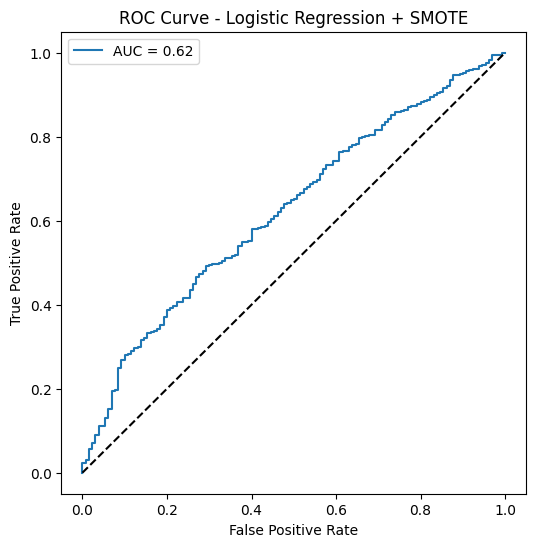

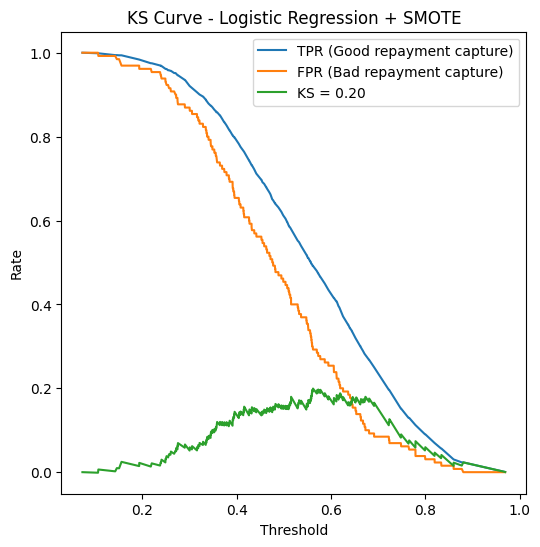

In [43]:
evaluate_credit_model(y_test, y_prob_log, "Logistic Regression + SMOTE")


📊 RandomForest + SMOTE Performance
AUC-ROC: 0.588
KS Statistic: 0.147
Gini Coefficient: 0.175

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     235    0.979167
8         240     231    0.962500
7         240     227    0.945833
6         240     229    0.954167
5         240     227    0.945833
4         240     229    0.954167
3         240     228    0.950000
2         240     217    0.904167
1         240     227    0.945833
0         240     220    0.916667


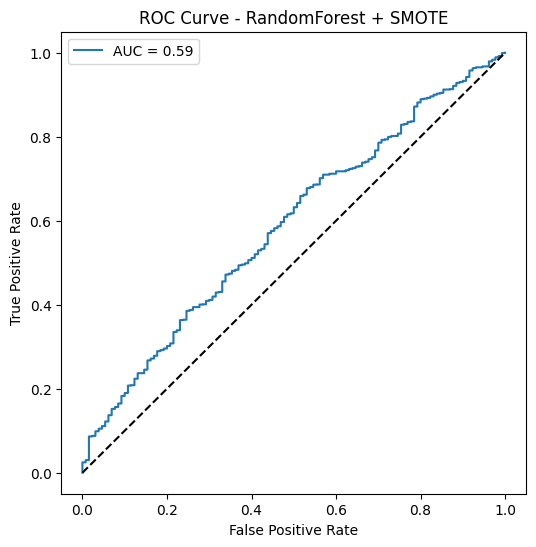

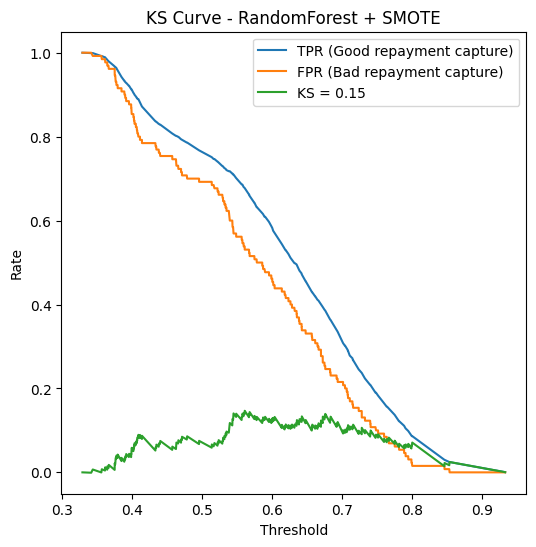

In [44]:
evaluate_credit_model(y_test, y_prob_rf, "RandomForest + SMOTE")


📊 Fairness-Aware Logistic (Reweighted) Performance
AUC-ROC: 0.638
KS Statistic: 0.236
Gini Coefficient: 0.275

Decile-wise Lift Analysis:
        total  events  event_rate
decile                           
9         240     235    0.979167
8         240     233    0.970833
7         240     236    0.983333
6         240     231    0.962500
5         240     226    0.941667
4         240     221    0.920833
3         240     227    0.945833
2         240     225    0.937500
1         240     220    0.916667
0         240     216    0.900000


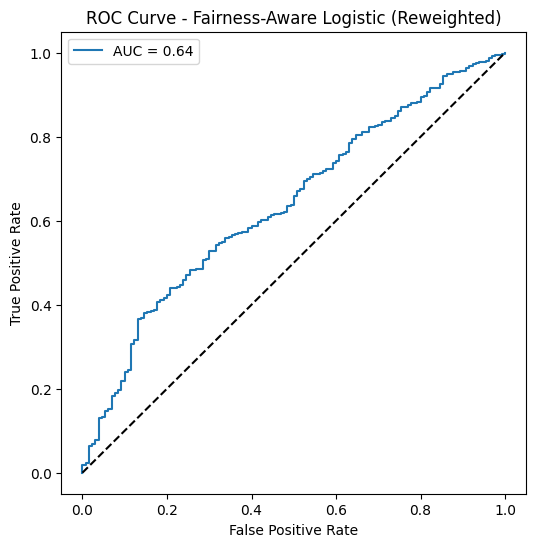

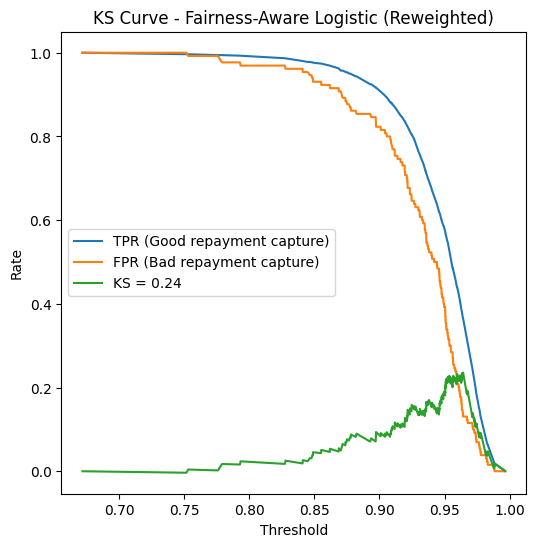

In [45]:
evaluate_credit_model(y_test, y_prob_fair, "Fairness-Aware Logistic (Reweighted)")